In [1]:
# MY SIMULATION 
import itertools
%matplotlib inline
import os
import random 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import vertex_model as model
# from vertex_model.run_select_nosaveinfo import run_simulation_INM, definecolors, run_simulation_no_INM
import itertools
import numpy as np
import matplotlib.pyplot as plt
import vertex_model as model
import vertex_model.initialisation as init
import vertex_model.characterization as crt
from vertex_model.forces import TargetArea, Tension, Perimeter, Pressure
import os
import seaborn as sns
import warnings
import matplotlib.colors as colors
warnings.filterwarnings('ignore') #Don't show warnings
#from Gobal_Constant import dt, viscosity, t_G1, t_G2, t_S, A_c, J, pos_d, T1_eps, P, microns, time_hours, expansion_constant #file with necessary constants
from vertex_model.run_select import save_data
sns.set_style("whitegrid")
from scipy.spatial import Delaunay
import math
from scipy.spatial import ConvexHull

In [6]:
#Global constants
#Global constants
dt=0.001      #time step
viscosity= 0.02  #viscosity*dv/dt = F
P= 0.0
expansion_constant = 1
Number_simulations = 50
K=1.0 #area elasticity
G= 0.04 #contractility of the cell
L=0.06 #line tensions
Lambda_0 = 0.75 #Line tensions can be reduced by increasing cell-cell adhesion or reducing actin- myosin contractility
t_end = 25
area_dimension= 177 #np.pi*(15/2.0)**2 #15 micrometros de diámetro

In [3]:
# run simulation
def run(simulation,N_step,skip):
    N_step = math.floor(N_step)
    skip = math.floor(skip)
    iter =  itertools.islice(simulation,0,N_step,skip)
    return [cells.copy() for cells in itertools.islice(simulation,0,N_step,skip)]

#simulation without division
def basic_simulation(cells,force,dt=dt,T1_eps=0.04):
    expansion = np.array([0.0,0.0])
    while True:
#         print cells.properties['parent_group']
        cells.mesh , number_T1, edg_rem = cells.mesh.transition(T1_eps)
#         cells.properties['Gamma'][cells.mesh.face_ids == 50]=np.array([0.0])
        F = force(cells)/viscosity
#         expansion = 0.05*np.average(F*cells.mesh.vertices,1)*dt
        dv = dt*model.sum_vertices(cells.mesh.edges,F) 
#         cells.mesh = cells.mesh.moved(dv).scaled(1.0+ expansion)
        if hasattr(cells.mesh.geometry,'width'):
            expansion[0] = expansion_constant*np.average(F[0]*cells.mesh.vertices[0])*dt/(cells.mesh.geometry.width**2)
        if hasattr(cells.mesh.geometry,'height'): #Cylinder mesh doesn't have 'height' argument
            expansion[1] = np.average(F[1]*cells.mesh.vertices[1])*dt/(cells.mesh.geometry.height**2)
        cells.mesh = cells.mesh.moved(dv).scaled(1.0+expansion)
        yield cells

In [4]:
def definecolors(cells):
    peach = '#eed5b7'
    light_blue ='#87cefa'
    pink = '#ffc0cb'
    light_green = '#98fb98'
    import matplotlib.colors as colors
    vv=sns.color_palette("hls", 10)
    v=[colors.rgb2hex(colorrgb) for colorrgb in vv]
    palette = np.array([light_green, pink,light_green,'g','r','g','m','c','',peach])
    palette = np.array([v[0],v[1],v[1], v[1],v[4],v[5],v[6],v[7],v[8],v[9],peach])
    colors = cells.properties['parent_group']
    return palette[colors]

In [27]:
simulations = [] # to store the different simulations for the different values of noise
noise=0
ncellup = 16
ncellacross =  16
ncells = ncellacross*ncellup
# ecad_cells_proportion = 0.04
# ecad_cells = int(ecad_cells_proportion* ncells)
# id_ecad_cells = random.sample(range(ncells), ecad_cells); print(id_ecad_cells)
mutant_cells_vec = np.arange(0., 0.125, 0.015) #different proportions of mutant cells in the mesh
ecad_cells_vec = []
#id_ecad_cells_vec = np.zeros[len(mutant_cells_vec)]
for j, m in enumerate(mutant_cells_vec):
    history_10={}
    ecad_cells = int(m * ncells)
    id_ecad_cells = random.sample(range(ncells), ecad_cells); print(id_ecad_cells)
    ecad_cells_vec.append(id_ecad_cells)
     
    #ids_Gamma0 = random.sample(range(1, 100), 10)
    for i in range(1):
        #run simulation with the choosen parameters
        rand =  np.random.RandomState() #random number to choose Lambda
        params = [K,G,L]  # K=x[0],G=x[1],L=x[2]
        hex_centres = init.hexagonal_centres(ncellup, ncellacross, noise, rand= np.random.RandomState())
        # create a voronoi mesh with those centres 
        mesh = init.toroidal_ic_mesh(hex_centres)
        cells = model.Cells(mesh,properties={'K':K,'Gamma':G,'P':0.0,'boundary_P':P,'Lambda':L, 'Lambda_boundary':0.5, 'A0':1.0})
        force = TargetArea() + Tension() + Perimeter() + Pressure()
        step = int(50/dt)
        history_init_10= run(basic_simulation(cells,force),step,int(1/dt)) 
        expansion_constant = 1
        cells = history_init_10[-1].copy()
        cells.properties['parent_group'] = np.zeros(len(cells),dtype=int)
        if id_ecad_cells != []:
            cells.properties['parent_group'][np.where([cells.mesh.face_ids == index for index in id_ecad_cells])[1]] = 1
        cells.properties['Gamma']= np.array([G,0])[cells.properties['parent_group']]
        cells.properties['Lambda']= np.array([L,Lambda_0])[cells.properties['parent_group']]
        force = TargetArea() + Tension() + Perimeter() + Pressure()
        N_Step = math.floor(t_end/dt)
        history_10[i]= run(basic_simulation(cells,force),N_Step,.010/dt) 
        #save_data(i,history_10[i],'cells10')
    simulations.append(history_10[i])


[183, 0, 148, 137, 127, 99, 222, 36, 162, 217, 17, 229, 25, 252, 83, 45, 209, 119, 35, 193, 32, 242, 212, 230, 98]
[39, 121, 48, 215, 233, 251, 220, 150, 67, 93, 172, 229, 64, 147, 135, 178, 27, 149, 119, 155, 73, 179, 47, 54, 198, 92, 186, 250, 104]


In [28]:
fluid_like = np.zeros((len(simulations), 1))
all_si = []
for k, sim in enumerate(simulations):
    shape_indices = []
    t = 2000
    for i in range(t): #bucle por todos los time steps 
        mesh_i = sim[i].mesh
        index_shape = []
        for j in range(len(mesh_i.area)): # bucle por cada area de cada celula en un time step 
            l = mesh_i.perimeter[j]
            a = mesh_i.area[j]
            if ((a != 0) and (l !=0)):
                si = l/np.sqrt(a)
                if not np.isnan(si): 
                    

                    index_shape.append(si)
            
        shape_indices.append(np.mean(index_shape)) # shape index de una sola simulacion a lo largo de t 
    for t, s in enumerate(shape_indices):
        if s > 3.81: 
            fluid_like[k] = 1
            break
    all_si.append(shape_indices)
        

## Shape index characterization depending on the number of mutant cells in the mesh 


[3.7224194912044983, 3.7507156024330057, 3.7725733966225703, 3.786360775935515, 3.7696194506673635, 3.7620207615942554, 3.80564389393665, 3.7836426245526544, 3.7897763838787526, 3.811729387165258, 3.7608091019597962, 3.7884862938988833]


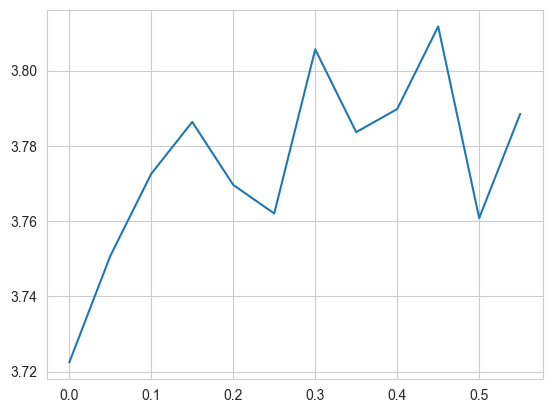

In [15]:
shape_index_means = []
for i in range(len(simulations)):
    last_mesh_i = simulations[i][0][-1].mesh
    index_shape = []
    for j in range(len(last_mesh_i.area)):
        l = last_mesh_i.perimeter[j]
        a = last_mesh_i.area[j]
        if (a != 0) & (l !=0):
            index_shape.append(l/np.sqrt(a))
    

    shape_index_means.append(np.mean(index_shape))
print(shape_index_means)
plt.plot(mutant_cells_vec, shape_index_means) 

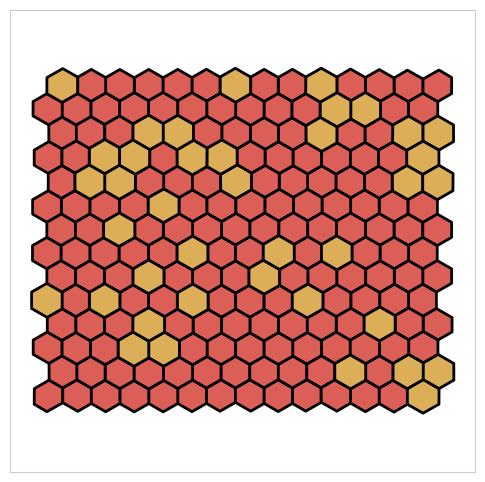

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [8]:
i=4
hh = simulations[i][0]
for cells in hh:
    #ids_nofronter = [1,15,30,6,98, 23,42,56,68,71]
    #cells.properties['parent_group'] = np.zeros(len(cells),dtype=int)
    #cells.properties['parent_group'][np.where([cells.mesh.face_ids == index for index in ids_nofronter])[1]] = 1
    cells.properties['color'] = definecolors(cells)
    cells.properties['parent_group'] = np.zeros(len(cells),dtype=int)
    #ids_Gamma0 = [1,15,30,6,98,23,42,56,68,71]
    #cells.properties['parent_group'][np.where([cells.mesh.face_ids == index for index in ids_Gamma0])[1]] = 1
# definition of the frame for the interactive video
history_10_plot = hh[0:40]#+history1
fig=plt.figure()
fig.set_size_inches(6,6);
ax = fig.gca()
# initialization function: plot the background of each frame
def init_fig():
    ax = plt.figure();
    return (ax,)
# animation function. This is called sequentially
def animate_fig(i):
    cells_array=history_10_plot
    v_max = np.max((np.max(cells_array[-1].mesh.vertices), np.max(cells_array[0].mesh.vertices)))
    size = 2.0*v_max
    cells= history_10_plot[i]
    return model.draw(cells,ax,size)
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig,animate_fig, init_func=init_fig,
                               frames=(len(history_10_plot)))
HTML(anim.to_html5_video())